In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Define the directory
dataset_path = "/content/drive/MyDrive/DataSet"

In [ ]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_path)

Found 9694 files belonging to 2 classes.


In [ ]:
# Load training dataset with validation split
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% for validation
    subset="training",  # Load the training subset
    seed=123,  # Random seed for reproducibility
    image_size=(224, 224),  # Resize all images to 224x224 (required for VGG16)
    batch_size=128  # Batch size
)

Found 9694 files belonging to 2 classes.
Using 7756 files for training.


In [ ]:
# Load validation dataset with validation split
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # Same split ratio
    subset="validation",  # Load the validation subset
    seed=123,  # Same seed to ensure matching split
    image_size=(224, 224),  # Resize images (required for VGG16)
    batch_size=128   # Batch size
)

Found 9694 files belonging to 2 classes.
Using 1938 files for validation.


In [ ]:
# Define the batch size and print the image labels
class_names = dataset.class_names
print(class_names)

def preprocess_image(image, label):
    # Normalize the pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=len(class_names))
     # Convert integer labels to one-hot encoded labels
    return image, label

['dog', 'spider']


In [ ]:
# Apply preprocessing to both datasets
ds_train = ds_train.map(preprocess_image)
ds_validation = ds_validation.map(preprocess_image)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Freeze the base model layers
base_model.trainable = False

In [ ]:
# Add custom layers on top of the pre-trained VGG16 model
x = base_model.output

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

# Add custom layers on top of the pre-trained base
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

In [ ]:
# Define the full model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model with Adam optimizer and learning rate 0.0001
adam_optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',  # Suitable for one-hot encoded labels
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [ ]:
# Display model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,282 (105.14 MB)

 Trainable params: 12,846,594 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history = model.fit(ds_train,  # Training dataset
                    epochs=10,  # Number of epochs
                    validation_data=ds_validation)  # Validation dataset

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.6863 - loss: 0.6373 - val_accuracy: 0.9376 - val_loss: 0.3880
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 669ms/step - accuracy: 0.9386 - loss: 0.3238 - val_accuracy: 0.9499 - val_loss: 0.2039
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 43s 709ms/step - accuracy: 0.9559 - loss: 0.1783 - val_accuracy: 0.9608 - val_loss: 0.1399
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 686ms/step - accuracy: 0.9598 - loss: 0.1305 - val_accuracy: 0.9644 - val_loss: 0.1149
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - accuracy: 0.9700 - loss: 0.1034 - val_accuracy: 0.9685 - val_loss: 0.0962
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 664ms/step - accuracy: 0.9730 - loss: 0.0872 - val_accuracy: 0.9706 - val_loss: 0.0864
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 44s 705ms/step - accuracy: 0.9752 - loss: 0.0761 - val_accuracy: 0.9742 - val_loss: 0.0801
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 42s 690ms/step - accuracy: 0.9767 - loss: 0.0688 - val_accura

In [ ]:
# Plot accuracy over epochs
k = 'accuracy' if 'accuracy' in history.history else 'acc'

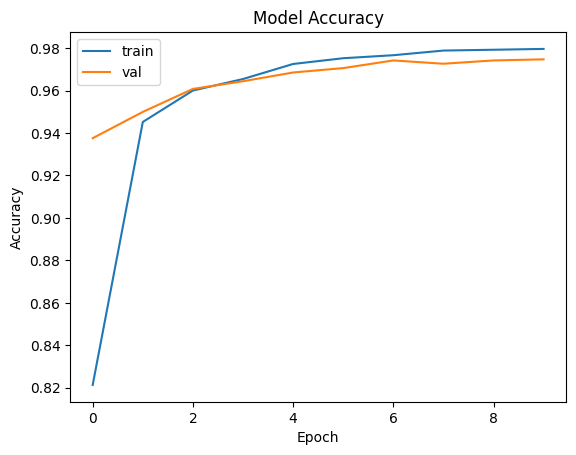

In [ ]:
if k != '':
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(ds_validation)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.9753 - loss: 0.0731
Validation Accuracy: 97.47%


In [ ]:
# Get predictions on the validation set
y_true = []
y_pred = []

In [ ]:
for images, labels in ds_validation:
    # Get true labels and predictions
    y_true.append(tf.argmax(labels, axis=1).numpy())
    y_pred.append(tf.argmax(model.predict(images), axis=1).numpy())

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


In [ ]:
# Flatten the lists
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
# Convert one-hot encoded labels and predictions to class indices
#y_true = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in ds_validation])
#y_pred = np.concatenate([np.argmax(model.predict(images), axis=1) for images, _ in ds_validation])

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

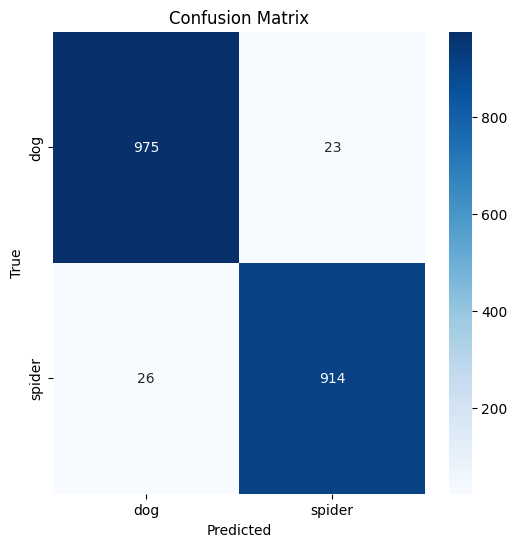

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Display classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

         dog       0.97      0.98      0.98       998
      spider       0.98      0.97      0.97       940

    accuracy                           0.97      1938
   macro avg       0.97      0.97      0.97      1938
weighted avg       0.97      0.97      0.97      1938

